# Background and Objective
As the market for electric vehicles continues to expand, accurately classifying the types of electric vehicles becomes crucial for various stakeholders, including manufacturers, policymakers, and consumers. Understanding the distribution of BEV and PHEV vehicles in the market can provide valuable insights for infrastructure planning, policy-making, and targeting the right market segments. By developing an accurate classification model, this project aims to contribute to the advancement of electric vehicle research, development, and decision-making.

The objective of this project is to develop a classification model that can accurately identify the type of electric vehicle, distinguishing between Battery Electric Vehicles (BEV) and Plug-in Hybrid Electric Vehicles (PHEV), with the aim of gaining in-depth knowledge and insights into electric vehicle classification.

Dataset:<br>
Electric Vehicle Population
<br>(https://www.kaggle.com/datasets/gunapro/electric-vehicle-population-data)
<br>17 columns</br>130.443 rows</br>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

# modeling
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# splitting data and model evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# sampling
from imblearn.under_sampling import NearMiss
from collections import Counter

# cross-validation and hyperparameter tuning
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

# feature importance
import shap

# Load Dataset

In [2]:
# read data
df = pd.read_csv('Electric_Vehicle_Population_Data.csv', encoding='utf-8', sep=';')

# print shape of data
print('Number of instances : ', df.shape[0])
print('Number of features : ', df.shape[1])

df.head(5)

Number of instances :  130443
Number of features :  17


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJXCAE26J,Yakima,Yakima,WA,98908.0,2018,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0,14.0,141151601,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10
1,JHMZC5F37M,Kitsap,Poulsbo,WA,98370.0,2021,HONDA,CLARITY,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,47,0,23.0,171566447,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303509e+10
2,5YJ3E1EB0K,King,Seattle,WA,98199.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0,36.0,9426525,POINT (-122.40092 47.65908),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
3,1N4AZ0CP5D,King,Seattle,WA,98119.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,0,36.0,211807760,POINT (-122.3684 47.64586),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
4,5YJSA1E21H,Thurston,Lacey,WA,98516.0,2017,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,22.0,185810306,POINT (-122.75379 47.06316),PUGET SOUND ENERGY INC,5.306701e+10


In [3]:
# show data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130443 entries, 0 to 130442
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         130443 non-null  object 
 1   County                                             130440 non-null  object 
 2   City                                               130440 non-null  object 
 3   State                                              130443 non-null  object 
 4   Postal Code                                        130440 non-null  float64
 5   Model Year                                         130443 non-null  int64  
 6   Make                                               130443 non-null  object 
 7   Model                                              130221 non-null  object 
 8   Electric Vehicle Type                              130443 non-null  object

In [4]:
df.shape

(130443, 17)

In [5]:
# initialize category and numeric data
category = [i for i in df.columns if df[i].dtype == 'object']
numerical = [i for i in df.columns if df[i].dtype != 'object']

In [6]:
# show statistical summary of numeric data
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Postal Code,130440.0,9.816763e+04,2.492198e+03,1.730000e+03,9.805200e+04,9.812100e+04,9.837000e+04,9.970100e+04
Model Year,130443.0,2.019555e+03,2.989137e+00,1.997000e+03,2.018000e+03,2.020000e+03,2.022000e+03,2.023000e+03
Electric Range,130443.0,7.670572e+01,9.942157e+01,0.000000e+00,0.000000e+00,2.300000e+01,1.510000e+02,3.370000e+02
Base MSRP,130443.0,1.495677e+03,9.844748e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.450000e+05
Legislative District,130138.0,2.957703e+01,1.476751e+01,1.000000e+00,1.800000e+01,3.400000e+01,4.300000e+01,4.900000e+01
DOL Vehicle ID,130443.0,2.051796e+08,8.710573e+07,4.385000e+03,1.568004e+08,2.034934e+08,2.290791e+08,4.792548e+08
2020 Census Tract,130440.0,5.297177e+10,1.640658e+09,1.081042e+09,5.303301e+10,5.303303e+10,5.305307e+10,5.603300e+10


In [7]:
# show statistical summary of category data
df[category].describe().T

,count,unique,top,freq
VIN (1-10),130443,8827,5YJYGDEE0M,467
County,130440,166,King,68477
City,130440,656,Seattle,22894
State,130443,46,WA,130138
Make,130443,35,TESLA,59629
Model,130221,121,MODEL 3,25311
Electric Vehicle Type,130443,2,Battery Electric Vehicle (BEV),100156
Clean Alternative Fuel Vehicle (CAFV) Eligibility,130443,3,Clean Alternative Fuel Vehicle Eligible,60551
Vehicle Location,130410,773,POINT (-122.13158 47.67858),3384
Electric Utility,130440,75,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),47490


# Data Preparation

## Preprocessing

### Duplicate Value

In [8]:
# show duplicated data
df.duplicated().sum()

0

### Missing Value

In [9]:
# show missing values of data
df.isnull().sum()

VIN (1-10)                                             0
County                                                 3
City                                                   3
State                                                  0
Postal Code                                            3
Model Year                                             0
Make                                                   0
Model                                                222
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 305
DOL Vehicle ID                                         0
Vehicle Location                                      33
Electric Utility                                       3
2020 Census Tract                                      3
dtype: int64

In [10]:
# show columns that have missing values
df.columns[df.isnull().any()]

Index(['County', 'City', 'Postal Code', 'Model', 'Legislative District',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')

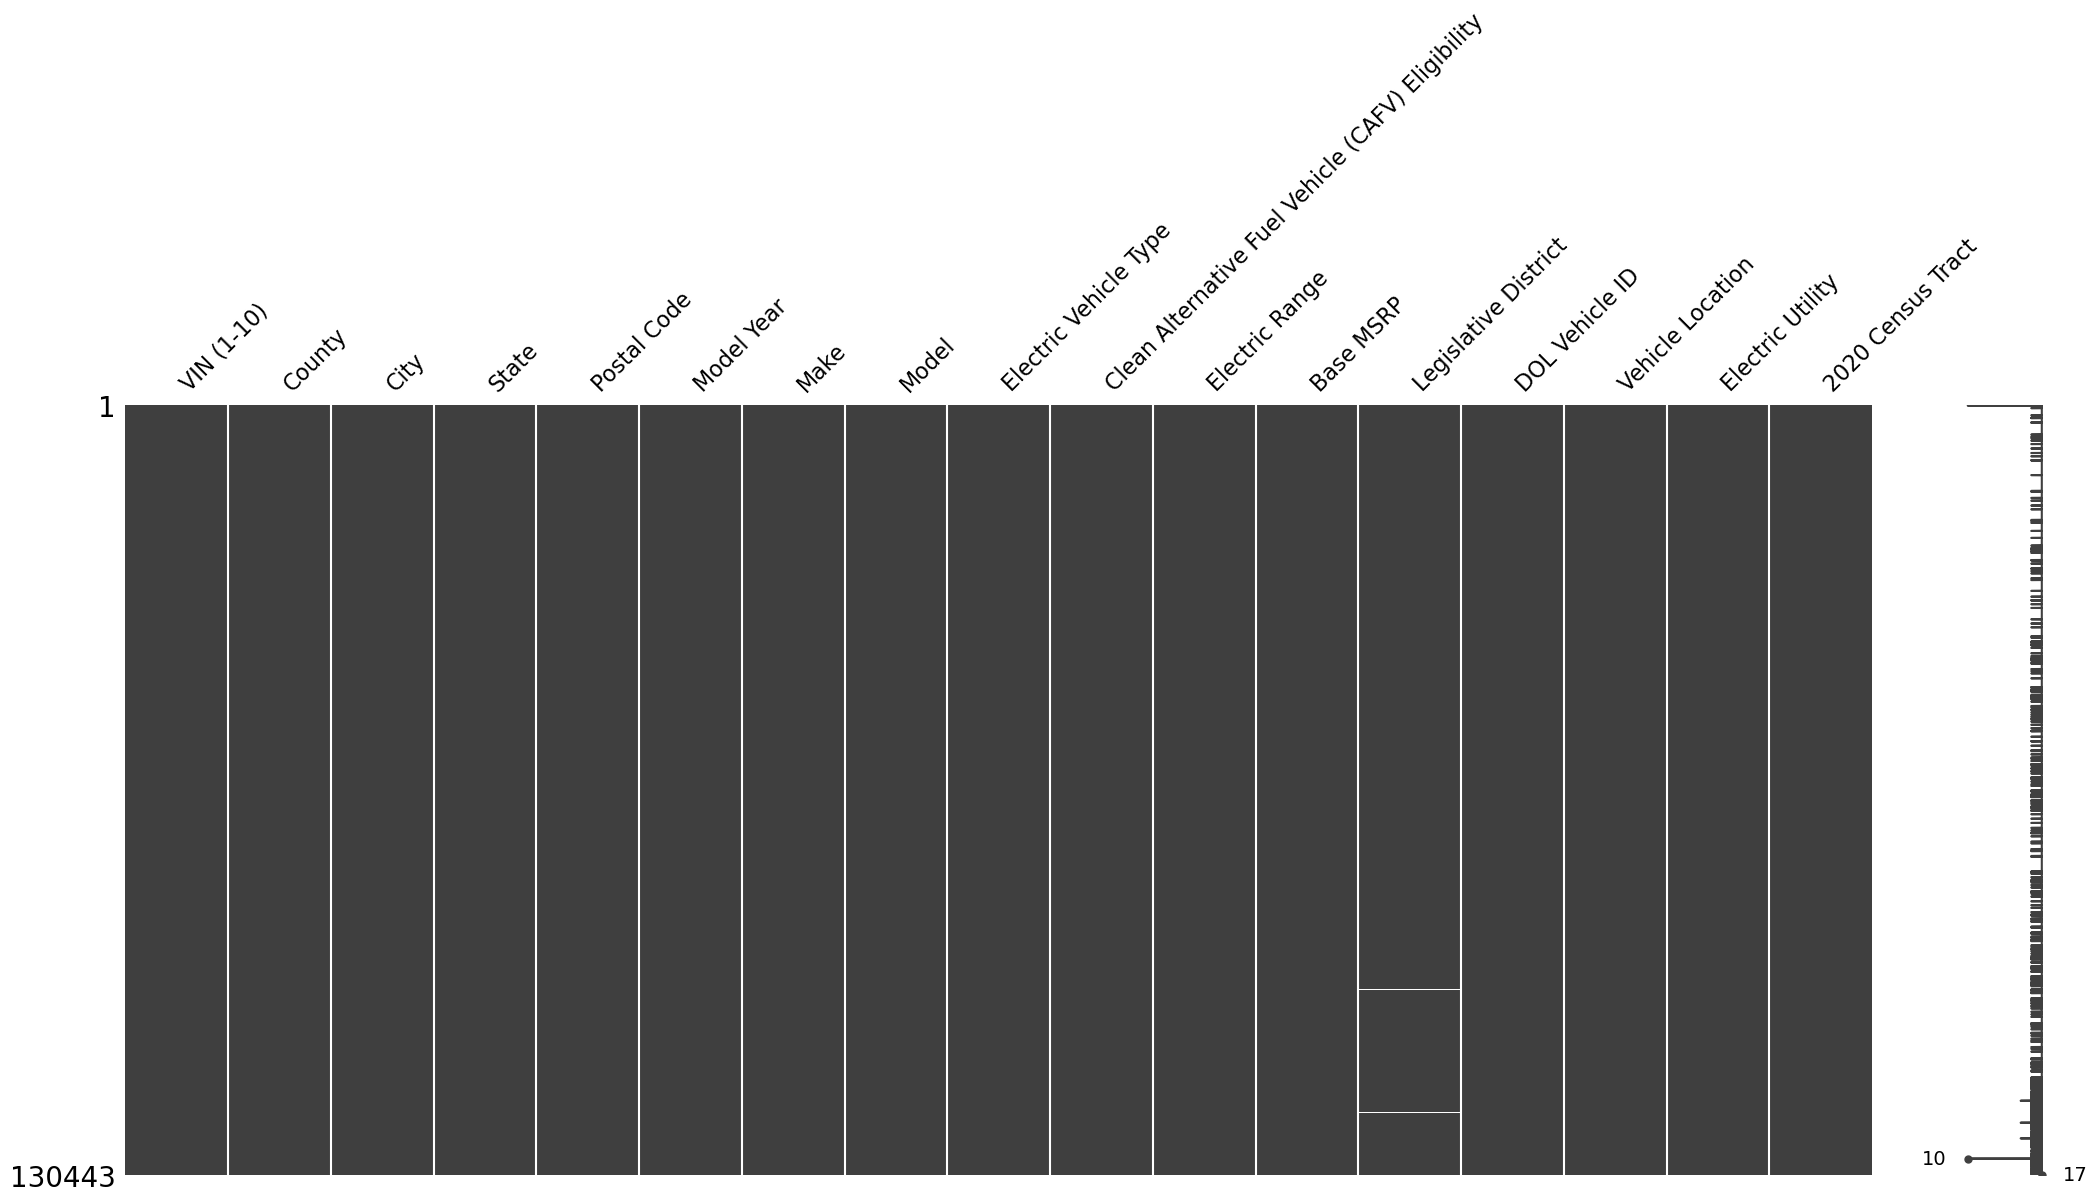

In [11]:
# plotting matrix of missing values
msno.matrix(df)
plt.show()

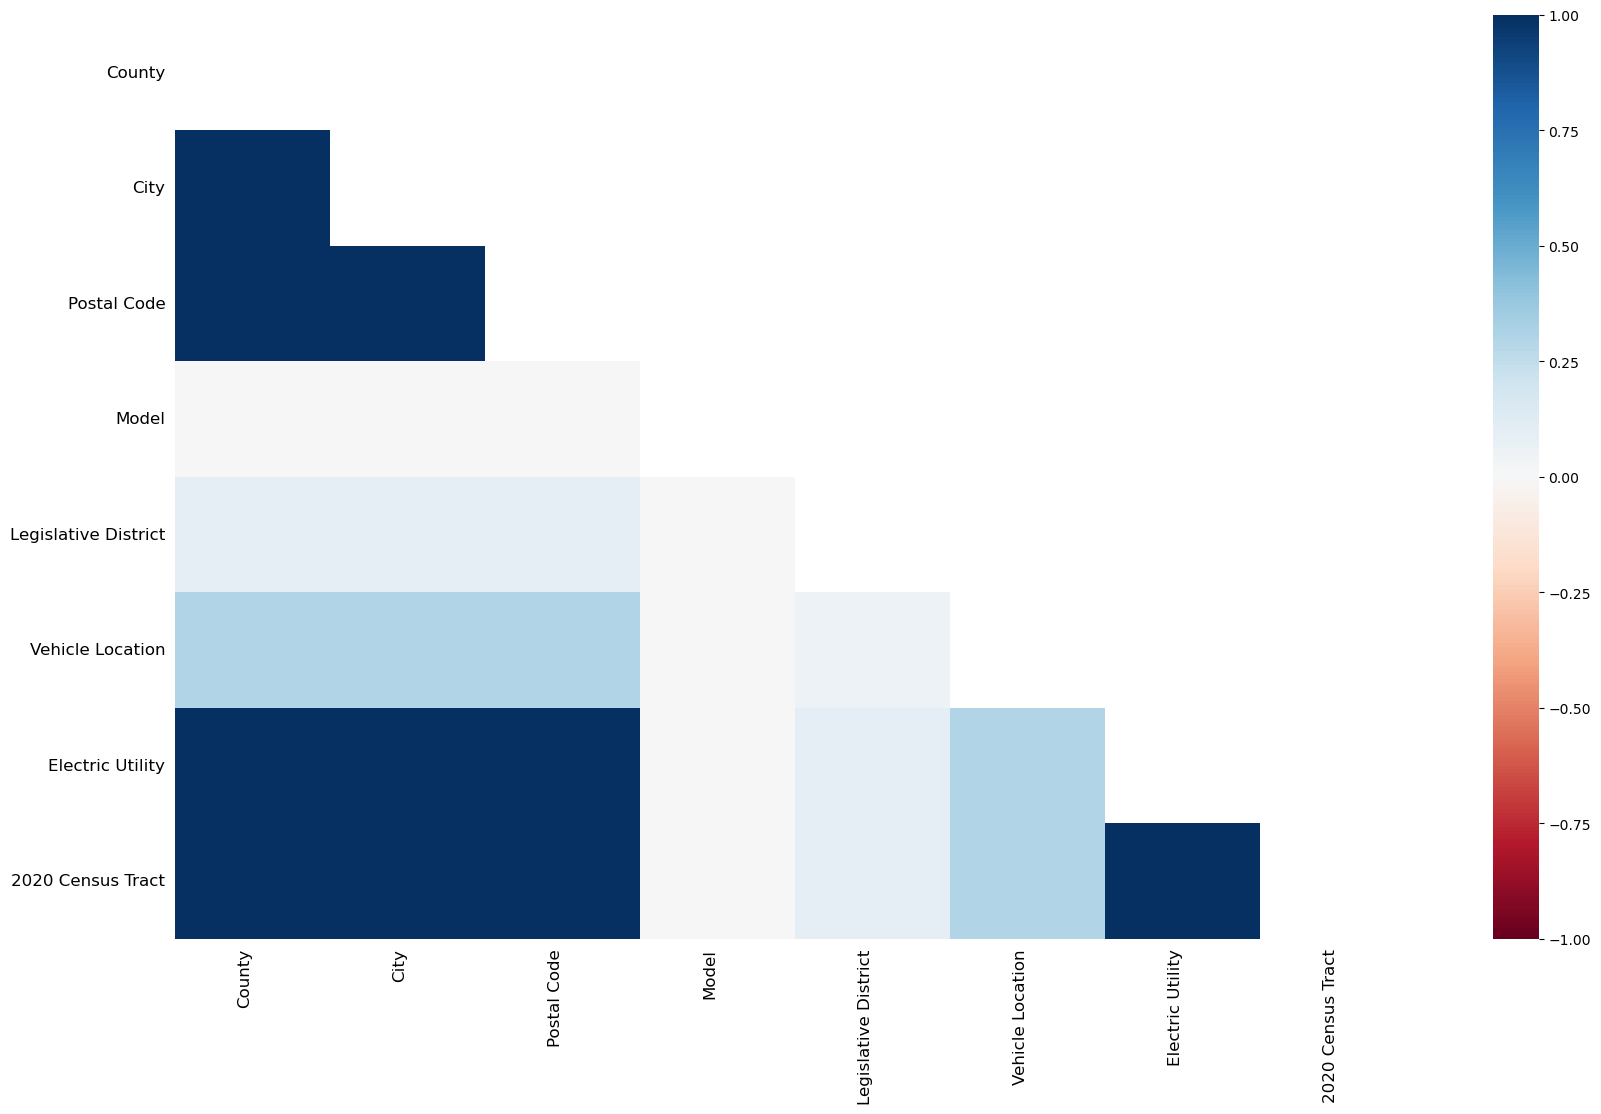

In [12]:
# get features that have missing values
missing_data = df.columns[df.isnull().any()]

# plotting heatmap of missing value
g = msno.heatmap(df[missing_data], fontsize=12, labels=False)
g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

Based on the heatmap above, it is known that there are several features that have a correlation with each other in the context of missing values such as City to County, Postal Code to City, Postal Code to County and others. This means, if one column has a missing value, then the other column will certainly have a missing value as well.

#### Drop Sample

In [13]:
# drop the missing values on the subset County and City
df = df.dropna(subset=['County', 'City']).reset_index(drop=True)

# show missing values of data
df.isnull().sum()

VIN (1-10)                                             0
County                                                 0
City                                                   0
State                                                  0
Postal Code                                            0
Model Year                                             0
Make                                                   0
Model                                                222
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 302
DOL Vehicle ID                                         0
Vehicle Location                                      30
Electric Utility                                       0
2020 Census Tract                                      0
dtype: int64

#### Imputation

In [14]:
# define a procudure to impute missing values for numeric data
def impute_numeric_data(data, columns, mode):
    for col in columns:
        if mode == 'median':
            value = data[col].median()
        elif mode == 'mean':
            value = data[col].mean()
        data[col].fillna(value, inplace=True)

# define a procudure to impute missing values for category data
def impute_categoric_data(data, columns):
    for col in columns:
        mode_value = data[col].mode().iloc[0]
        data[col].fillna(mode_value, inplace=True)
        
# apply imputation procedure for numeric and category data        
impute_numeric_data(df, ['Legislative District'], 'median')
impute_categoric_data(df, ['Model', 'Vehicle Location'])

# show missing values of data
df.isnull().sum()

VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64

### Feature Engineering

In [15]:
# update values in 'Electric Vehicle Type' column
df['Electric Vehicle Type'] = df['Electric Vehicle Type'].apply(lambda x: \
                                                                x.replace('Plug-in Hybrid Electric Vehicle (PHEV)', 'PHEV')
                                                                .replace('Battery Electric Vehicle (BEV)', 'BEV'))

# rename column 'Clean Alternative Fuel Vehicle (CAFV) Eligibility' to 'Clean Alternative Fuel Vehicle Eligibility'
df.rename(columns={'Clean Alternative Fuel Vehicle (CAFV) Eligibility': 'Clean Alternative Fuel Vehicle Eligibility'}, inplace=True)

# define a function to extract longitude and latitude from 'Vehicle Location' column
def extract_coordinates(point_string):
    coordinates = point_string.replace('POINT', '').replace('(', '').replace(')', '')
    longitude, latitude = coordinates.split()
    return float(longitude), float(latitude)

# apply the 'extract_coordinates' function to 'Vehicle Location' column and create new 'Longitude' and 'Latitude' columns
df[['Longitude', 'Latitude']] = df['Vehicle Location'].apply(extract_coordinates).apply(pd.Series)
df = df.drop('Vehicle Location', axis=1)

# define a function to map state codes to state names
def state_mapping(state_code):
    state_mapping = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
        'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
        'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
        'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
        'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
        'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
        'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
        'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
        'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
        'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
        'WI': 'Wisconsin', 'WY': 'Wyoming'
    }
    
    return state_mapping.get(state_code, 'Unknown')

# apply the 'state_mapping' function to 'State' column
df['State'] = df['State'].apply(state_mapping)

# define a function to extract the first substring from a column
def extract_substring(data, column_name):
    data[column_name] = data[column_name].str.split('-|\\|').str[0].str.strip()

# apply the 'extract_substring' function to 'Electric Utility' column
extract_substring(df, 'Electric Utility')

In [16]:
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude
0,5YJXCAE26J,Yakima,Yakima,Washington,98908.0,2018,TESLA,MODEL X,BEV,Clean Alternative Fuel Vehicle Eligible,238,0,14.0,141151601,PACIFICORP,5.307700e+10,-120.56916,46.58514
1,JHMZC5F37M,Kitsap,Poulsbo,Washington,98370.0,2021,HONDA,CLARITY,PHEV,Clean Alternative Fuel Vehicle Eligible,47,0,23.0,171566447,PUGET SOUND ENERGY INC,5.303509e+10,-122.64681,47.73689
2,5YJ3E1EB0K,King,Seattle,Washington,98199.0,2019,TESLA,MODEL 3,BEV,Clean Alternative Fuel Vehicle Eligible,220,0,36.0,9426525,CITY OF SEATTLE,5.303301e+10,-122.40092,47.65908
3,1N4AZ0CP5D,King,Seattle,Washington,98119.0,2013,NISSAN,LEAF,BEV,Clean Alternative Fuel Vehicle Eligible,75,0,36.0,211807760,CITY OF SEATTLE,5.303301e+10,-122.36840,47.64586
4,5YJSA1E21H,Thurston,Lacey,Washington,98516.0,2017,TESLA,MODEL S,BEV,Clean Alternative Fuel Vehicle Eligible,210,0,22.0,185810306,PUGET SOUND ENERGY INC,5.306701e+10,-122.75379,47.06316


### Encoding

In [17]:
# identify categorical columns in the DataFrame
category = [i for i in df.columns if df[i].dtype == 'object']

# iterate over each categorical column
for col in category:
    # print the value counts for the current column
    print(df[col].value_counts())
    print()

5YJYGDEE0M    467
5YJYGDEE9M    462
5YJYGDEE7M    453
5YJYGDEE8M    447
5YJYGDEE2M    440
             ... 
WP0AC2Y15N      1
50EA1DCA4N      1
WBY2Z4C55K      1
1V2VMPE87P      1
WBA13AG06M      1
Name: VIN (1-10), Length: 8826, dtype: int64

King                    68477
Snohomish               14651
Pierce                  10019
Clark                    7700
Thurston                 4694
                        ...  
Wayne                       1
Marin                       1
Dorchester                  1
Sarpy                       1
Fairbanks North Star        1
Name: County, Length: 166, dtype: int64

Seattle        22894
Bellevue        6748
Redmond         4820
Vancouver       4652
Kirkland        4071
               ...  
Asheboro           1
Germantown         1
Saint Jacob        1
Watertown          1
Aurora             1
Name: City, Length: 656, dtype: int64

Washington        130138
California            83
Virginia              35
Maryland              29
Texas          

In [18]:
# show category columns
df[category].columns

Index(['VIN (1-10)', 'County', 'City', 'State', 'Make', 'Model',
       'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle Eligibility',
       'Electric Utility'],
      dtype='object')

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce

# define a function to encode category data into numeric
def encode_data(data, columns, method):
    
    # one-hot encoding
    if method == 'ohe':
        encoded_columns = pd.get_dummies(data[columns], prefix=columns)
        data = pd.concat([data, encoded_columns], axis=1)
        data.drop(columns, axis=1, inplace=True)   
        
    # ordinal encoding
    elif method == 'ordinal':
        ordinal_enc = OrdinalEncoder()
        encoded_columns = ordinal_enc.fit_transform(data[columns])
        data[columns] = encoded_columns
        data[columns] = encoded_columns.astype(int)
      
    # frequency encoding
    elif method == 'frequency':
        encoder = ce.CountEncoder(cols=columns)
        data = encoder.fit_transform(data)
        
        # for column in columns:
        #     frequency_encoding = data[column].value_counts(normalize=True).to_dict()
        #     data[column] = data[column].replace(frequency_encoding)
    
    return data

In [20]:
# define ordinal and frequency columns as list
ordinal_columns = ['State', 'Make', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle Eligibility']
frequency_columns = ['VIN (1-10)', 'County', 'City', 'Model', 'Electric Utility']

train = df.copy()

# apply the 'encode_data' function to 'ordinal_columns' and 'frequency_columns'
train = encode_data(train, ordinal_columns, method='ordinal')
train = encode_data(train, frequency_columns, method='frequency')

train

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude
0,25,709,471,41,98908.0,2018,29,4792,0,0,238,0,14.0,141151601,968,5.307700e+10,-120.569160,46.585140
1,1,4344,521,41,98370.0,2021,11,782,1,0,47,0,23.0,171566447,76184,5.303509e+10,-122.646810,47.736890
2,221,68477,22894,41,98199.0,2019,29,25532,0,0,220,0,36.0,9426525,24236,5.303301e+10,-122.400920,47.659080
3,172,68477,22894,41,98119.0,2013,23,12960,0,0,75,0,36.0,211807760,24236,5.303301e+10,-122.368400,47.645860
4,62,4694,656,41,98516.0,2017,29,7399,0,0,210,0,22.0,185810306,76184,5.306701e+10,-122.753790,47.063160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130435,358,10019,1474,41,98335.0,2023,29,22078,0,1,0,0,26.0,231134102,25417,5.305307e+10,-122.583545,47.323449
130436,14,10019,2752,41,98408.0,2022,23,12960,0,1,0,0,29.0,185810943,25417,5.305306e+10,-122.438105,47.203220
130437,447,68477,22894,41,98109.0,2021,29,22078,0,1,0,0,36.0,176542418,24236,5.303301e+10,-122.350220,47.638240
130438,26,1444,356,41,98282.0,2020,29,4792,0,0,293,0,10.0,102834938,25417,5.302997e+10,-122.400490,48.239860


In [21]:
# show shape of df
df.shape

(130440, 18)

In [22]:
# show shape of train
train.shape

(130440, 18)

# Exploratory Data Analysis

In [23]:
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude
0,5YJXCAE26J,Yakima,Yakima,Washington,98908.0,2018,TESLA,MODEL X,BEV,Clean Alternative Fuel Vehicle Eligible,238,0,14.0,141151601,PACIFICORP,5.307700e+10,-120.56916,46.58514
1,JHMZC5F37M,Kitsap,Poulsbo,Washington,98370.0,2021,HONDA,CLARITY,PHEV,Clean Alternative Fuel Vehicle Eligible,47,0,23.0,171566447,PUGET SOUND ENERGY INC,5.303509e+10,-122.64681,47.73689
2,5YJ3E1EB0K,King,Seattle,Washington,98199.0,2019,TESLA,MODEL 3,BEV,Clean Alternative Fuel Vehicle Eligible,220,0,36.0,9426525,CITY OF SEATTLE,5.303301e+10,-122.40092,47.65908
3,1N4AZ0CP5D,King,Seattle,Washington,98119.0,2013,NISSAN,LEAF,BEV,Clean Alternative Fuel Vehicle Eligible,75,0,36.0,211807760,CITY OF SEATTLE,5.303301e+10,-122.36840,47.64586
4,5YJSA1E21H,Thurston,Lacey,Washington,98516.0,2017,TESLA,MODEL S,BEV,Clean Alternative Fuel Vehicle Eligible,210,0,22.0,185810306,PUGET SOUND ENERGY INC,5.306701e+10,-122.75379,47.06316


## Univariate Analysis

In [24]:
# parameter description
"""
Parameters:
    data (DataFrame): The input data.
    column (str): The variable to be plotted on the x-axis (or y-axis, based on the `orient` parameter).
    hue (str): The third variable to differentiate categories (optional).
    label (str): The label for the variable on the x-axis (or y-axis).
    max_sample (int): The maximum number of categories to be shown on the plot.
    num_x_ticks (int): The number of x-axis ticks to be customized.
    x_ticks (list): The list of x-axis tick labels to be customized.
    width (float): The width of the plot.
    height (float): The height of the plot.
    y_title (float): The distance between the title and the plot.
    orient (str): The orientation of the plot ('vertical' or 'horizontal').
    title (str): The title of the plot.
"""

# define a procedure to plot countplot for univariate analysis
def countplot_univariate(data, column, hue, label, max_sample, num_x_ticks, x_ticks, width, height, y_title, orient, title):
    
    # create a new figure with the specified width, height and title
    plt.figure(figsize=(width, height))
    plt.suptitle(f'{title}', y=y_title)

    # determine the order of the categories based on the maximum sample size
    order = data[column].value_counts().nlargest(max_sample).index if max_sample > 0 else data[column].value_counts().index

    # create a countplot based on the specified orientation
    if orient == 'vertical':
        g = sns.countplot(x=column, hue=hue, order=order, data=data, palette='muted')
        g.set(xlabel=label, ylabel='Number')
    elif orient == 'horizontal':
        g = sns.countplot(y=column, hue=hue, order=order, data=data, palette='muted')
        g.set(xlabel='Number', ylabel=label)

    plt.legend(title='Target', labels=['BEV', 'PHEV'], fontsize=11)

    # customize the x-axis ticks if the number of ticks is specified
    if num_x_ticks > 0:
        x_ticks_list = list(range(num_x_ticks))
        plt.xticks(x_ticks_list, x_ticks, fontsize=11)

    # calculate the total number of observations
    total = len(data[column])

    # add percentage annotations to the bars
    for p in g.patches:
        if orient == 'vertical':
            height = p.get_height()
            percentage = (height / total) * 100
            g.annotate(f'{percentage:.1f}%', (p.get_x() + (p.get_width() + 0.05) / 2, height + 1000), \
                            ha='center', va='bottom', fontsize=12)
        elif orient == 'horizontal':
            width = p.get_width()
            percentage = (width / total) * 100
            g.annotate(f'{percentage:.1f}%', (width + 250, p.get_y() + p.get_height() / 2), \
                       ha='left', va='center', fontsize=11)
            
    plt.show()

In [25]:
# define a function to change low-frequency category values into "Others"
def change_to_others(data, column_name, percent):
    
    data = data.copy()
    
    # calculate the value counts of the column as proportions, 
    value_counts = data[column_name].value_counts(normalize=True)
    
    # identify values with frequencies below the specified percentage threshold,
    low_frequency_values = value_counts[value_counts < percent].index
    
    # replace low-frequency values with "Others"
    data[column_name] = np.where(data[column_name].isin(low_frequency_values), "Others", data[column_name])

    return data

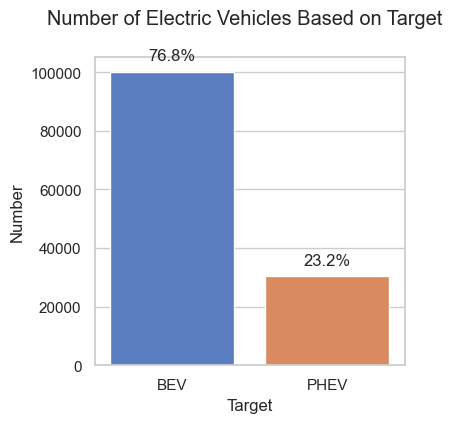

In [26]:
sns.set_theme(style="whitegrid")

chart = 'Number of Electric Vehicles Based on Target'

plt.figure(figsize=(4, 4))
plt.suptitle(f'{chart}', y=1)

# plotting countplot for the number of electric vehicles based on the target variable
g = sns.countplot(x='Electric Vehicle Type', data=df, palette='muted')
g.set(ylabel='Number', xlabel='Target')

# customize xticks
plt.xticks([0, 1], ['BEV', 'PHEV'], fontsize=11)

# annotate the percentage on the chart
total = len(df['Electric Vehicle Type'])
for p in g.patches:
            height = p.get_height()
            percentage = (height / total) * 100
            g.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2, height + 3000), \
                            ha='center', va='bottom', fontsize=12)

plt.show()

The graph above shows the distribution of the target variable, it is known that the number of PHEV electric vehicles is 23.2% of the total number of electric vehicles. It is concluded that there is an imbalance in the data on the target variable.

**Information**:<br>
**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

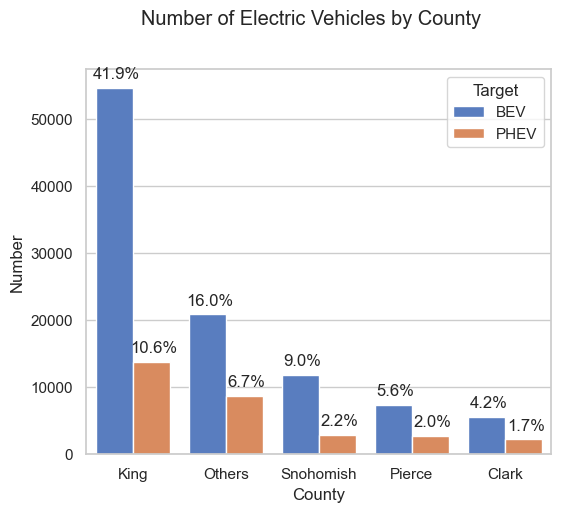

In [27]:
df2 = change_to_others(df, 'County', 0.05)

# initialize chart title
chart = 'Number of Electric Vehicles by County'

# apply the procedure to plot the chart
countplot_univariate(df2, 'County', 'Electric Vehicle Type', 'County', 0, 0, None, 6, 5, 1, \
                     'vertical', chart)

The graph above shows the distribution of the target variable by 'County'. The King area is the area with the highest number of electric vehicles with a percentage of 41.9% for BEV and 10.6% for PHEV.

**Information**:<br>
**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

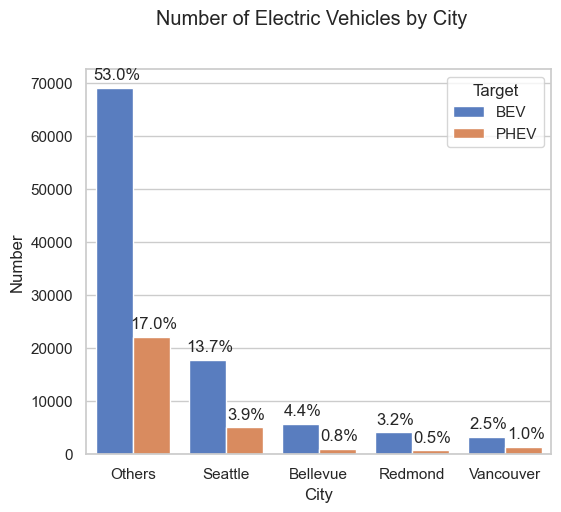

In [28]:
df2 = change_to_others(df, 'City', 0.035)

# initialize chart title
chart = 'Number of Electric Vehicles by City'

# apply the procedure to plot the chart
countplot_univariate(df2, 'City', 'Electric Vehicle Type', 'City', 0, 0, None, 6, 5, 1, \
                     'vertical', chart)

The graph above shows the distribution of target variables by 'City'. Seattle is the city with the second highest number of electric vehicles at 13.7% for BEV and 3.9% for PHEV. The rest of the cities fall into the category of cities with the highest number of electric vehicles at 53% for BEV and 17% for PHEV.

**Information**:<br>
**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

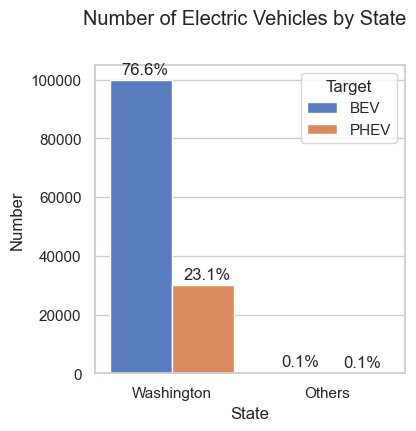

In [29]:
df2 = change_to_others(df, 'State', 0.01)

# initialize chart title
chart = 'Number of Electric Vehicles by State'

# apply the procedure to plot the chart
countplot_univariate(df2, 'State', 'Electric Vehicle Type', 'State', 0, 0, None, 4, 4, 1.02, \
                     'vertical', chart)

The graph above shows the distribution of target variables by 'State'. Washington is the state with the highest number of electric vehicles with a total percentage of 99.7% (BEV and PHEV).

**Information**:<br>
**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

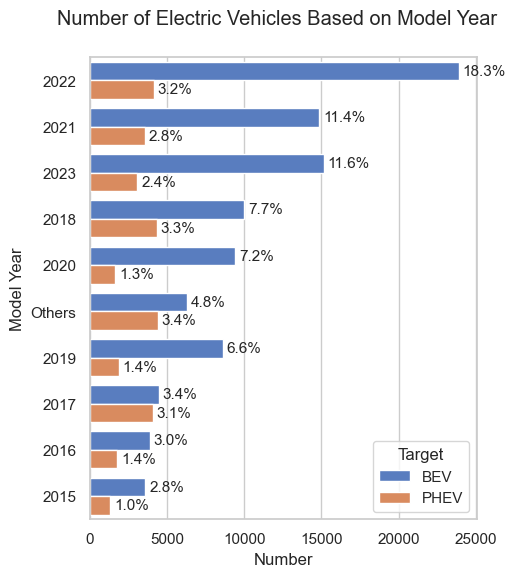

In [30]:
df2 = change_to_others(df, 'Model Year', 0.036)

# initialize chart title
chart = 'Number of Electric Vehicles Based on Model Year'

# apply the procedure to plot the chart
countplot_univariate(df2, 'Model Year', 'Electric Vehicle Type', 'Model Year', 0, 0, None, 5, 6, 0.96, \
                     'horizontal', chart)

The graph above shows the distribution of target variables by 'Model Year'. Electric vehicles with a model year of 2022 make up the largest percentage with 18.3% for BEVs and 3.2% for PHEVs. This is followed by 2021, 2023, 2018, 2020, other years, 2019, 2017, 2016, and 2015.

**Information**:<br>
**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

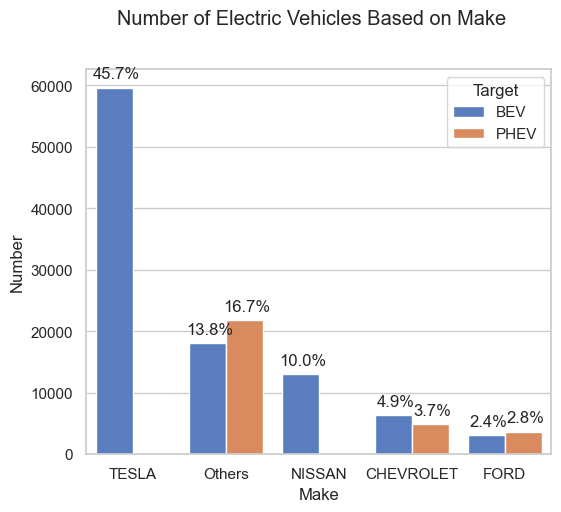

In [31]:
df2 = change_to_others(df, 'Make', 0.05)

# initialize chart title
chart = 'Number of Electric Vehicles Based on Make'

# apply the procedure to plot the chart
countplot_univariate(df2, 'Make', 'Electric Vehicle Type', 'Make', 0, 0, None, 6, 5, 1, \
                     'vertical', chart)

The graph above shows the distribution of target variables by 'Make'. Electric vehicles made by Tesla are most prevalent at 45.7% (BEV and PHEV), followed by other brands at 30.5% (BEV and PHEV), NISSAN at 10% (BEV and PHEV), and others.

**Information**:<br>
**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

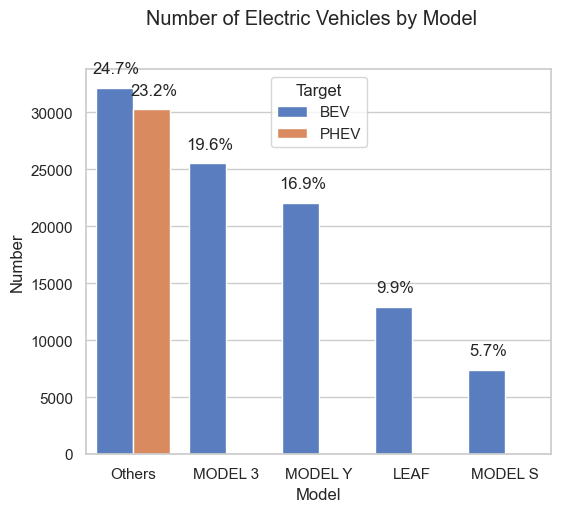

In [32]:
df2 = change_to_others(df, 'Model', 0.05)

# initialize chart title
chart = 'Number of Electric Vehicles by Model'

# apply the procedure to plot the chart
countplot_univariate(df2, 'Model', 'Electric Vehicle Type', 'Model', 0, 0, None, 6, 5, 1, \
                     'vertical', chart)

The graph above shows the distribution of target variables by 'Model'. Electric vehicles with miscellaneous models are the most prevalent with a percentage of 47.9% (BEV and PHEV), followed by MODEL 3, MODEL Y, LEAF, and MODEL S.

**Information**:<br>
**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

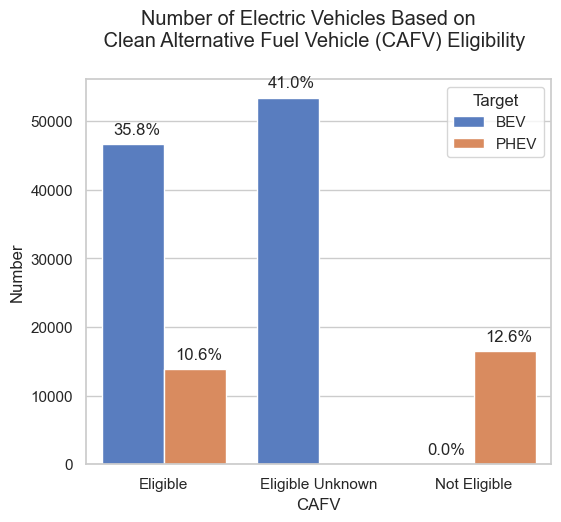

In [33]:
# initialize chart title
chart = 'Number of Electric Vehicles Based on \n Clean Alternative Fuel Vehicle (CAFV) Eligibility'

# apply the procedure to plot the chart
countplot_univariate(df, 'Clean Alternative Fuel Vehicle Eligibility', 'Electric Vehicle Type', 'CAFV', \
                     0, 3, ['Eligible', 'Eligible Unknown', 'Not Eligible'], 6, 5, 1.02, 'vertical', chart)

The graph above shows the distribution of target variables by 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'. Most electric vehicles meet the clean fuel vehicle (low emission) eligibility requirements at 46.4% (BEV and PHEV), followed by electric vehicles with unknown eligibility status at 41% (BEV and PHEV), and electric vehicles with ineligible status at 12.6% (BEV and PHEV).

**Information**:<br>
**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

**Clean Alternative Fuel Vehicle Eligibility** refers to the criteria or requirements that determine whether a vehicle is eligible to be classified as a Clean Alternative Fuel Vehicle (CAFV). CAFVs are vehicles that utilize alternative fuels or advanced technologies, such as electric vehicles, hybrid vehicles, hydrogen fuel cell vehicles, natural gas vehicles, or propane vehicles. These vehicles are considered more environmentally friendly and have reduced emissions compared to traditional gasoline or diesel vehicles.

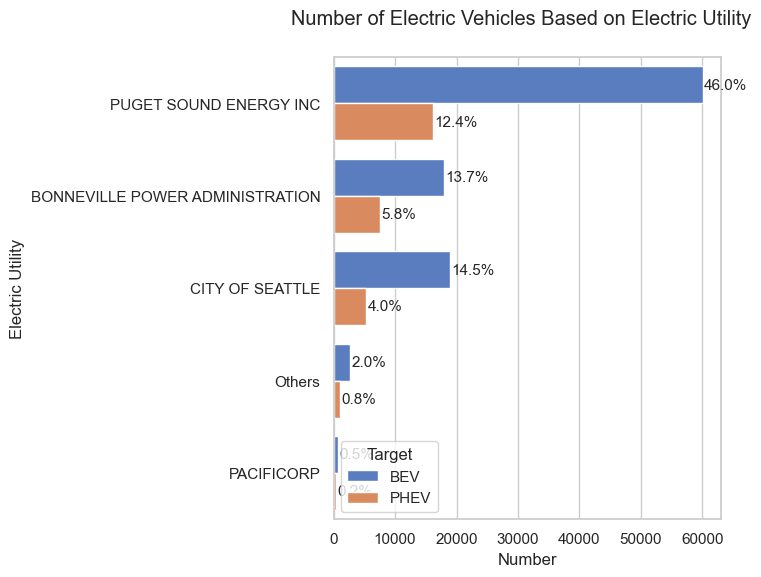

In [34]:
df2 = change_to_others(df, 'Electric Utility', 0.007)

# initialize chart title
chart = 'Number of Electric Vehicles Based on Electric Utility'

# apply the procedure to plot the chart
countplot_univariate(df2, 'Electric Utility', 'Electric Vehicle Type', 'Electric Utility', 0, 0, None, 5, 6, 0.96, \
                     'horizontal', chart)

The graph above shows the distribution of target variables by 'Electric Utility'. Electric vehicles with Puget Sound Energy electric utility are the most numerous at 58.4% (BEVs and PHEVs), followed by Bonneville Power Administration, City of Seattle, other, and Pacificorp.

**Information**:<br>
**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

## Bivariate Analysis 

In [35]:
# parameter description
"""
Parameters:
    data (DataFrame): The input data.
    x (str): The variable to be plotted on the x-axis.
    y (str): The variable to be plotted on the y-axis.
    hue (str): The variable used for grouping and distinguishing categories.
    label (str): The label for the y-axis.
    label2 (str): The label for the x-axis.
    width (float): The width of the chart.
    height (float): The height of the chart.
    y_title (float): The vertical position of the chart title.
    orient (str): The orientation of the chart ('vertical' or 'horizontal').
    title (str): The title of the chart.
        
"""

# define a procedure to plot boxplot for bivariate analysis
def boxplot_bivariate(data, x, y, hue, label, label2, width, height, y_title, orient, title):

    # set width, height, and title of the chart
    plt.figure(figsize=(width, height))
    plt.suptitle(f'{title}', y=y_title)

    # copy data for distribution processing and mapping the values
    df_biv = data.copy()
    df_biv[x] = df_biv[x].apply(lambda x: 'Eligible' if x == 'Clean Alternative Fuel Vehicle Eligible' \
                                else ('Unknown' if x == 'Eligibility unknown as battery range has not been researched' \
                                else 'Not Eligible'))

    # branching based on the orient parameter for plotting the chart vertically or horizontally
    if orient == 'vertical':
        g = sns.boxplot(x=x, y=y, hue=hue, showmeans=True, palette='muted', data=df_biv)
        g.set(xlabel=label2, ylabel=label)
    elif orient == 'horizontal':
        g = sns.boxplot(x=y, y=x, hue=hue, showmeans=True, palette='muted', data=df_biv)
        g.set(xlabel=label2, ylabel=label)

    plt.show()

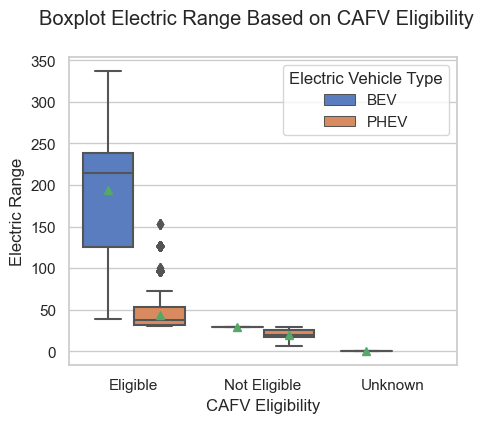

In [36]:
# initialize chart title
chart = 'Boxplot Electric Range Based on CAFV Eligibility'

# apply the procedure to plot the chart
boxplot_bivariate(df, 'Clean Alternative Fuel Vehicle Eligibility', 'Electric Range', \
                  'Electric Vehicle Type', 'Electric Range', 'CAFV Eligibility', 5, 4, 1, 'vertical', chart)


The distribution of the 'Electric Range' of BEV electric vehicles that are eligible under the clean fuel vehicle eligibility requirements is in the area of about 100 to 250.

**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

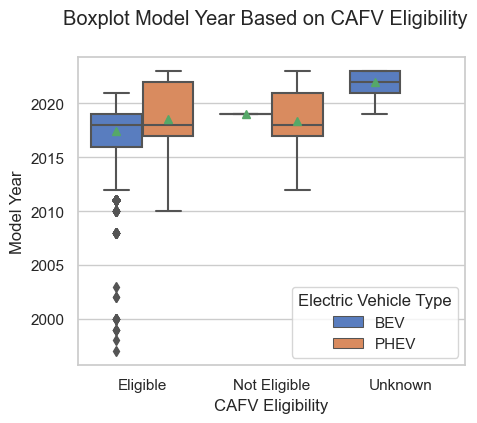

In [37]:
# initialize chart title
chart = 'Boxplot Model Year Based on CAFV Eligibility'

# apply the procedure to plot the chart
boxplot_bivariate(df, 'Clean Alternative Fuel Vehicle Eligibility', 'Model Year', \
                  'Electric Vehicle Type', 'Model Year', 'CAFV Eligibility', 5, 4, 1, 'vertical', chart)

Electric vehicle model years are in the 2010 to 2023 distribution area.

**BEV**: Battery Electric Vehicle<br>
**PHEV**: Plug-in Hybrid Electric Vehicle

## Correlation

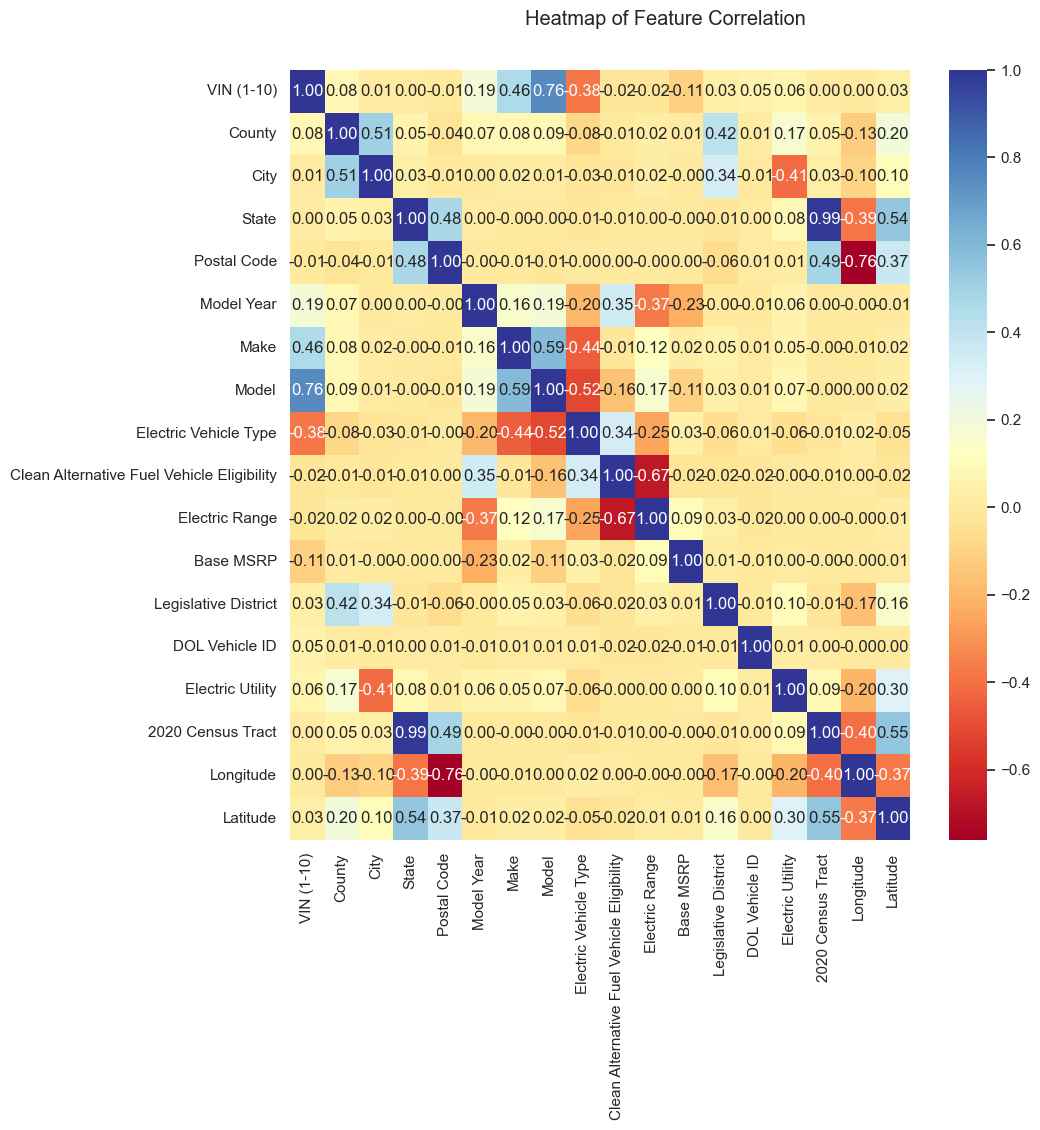

In [38]:
sns.set_theme(style="whitegrid")

chart = 'Heatmap of Feature Correlation'

plt.figure(figsize=(10, 10))
plt.suptitle(f'{chart}', y=0.94)

# plotting a heatmap of feature correlation
sns.heatmap(train.corr(), annot=True, cmap='RdYlBu', fmt='.2f')
plt.show()

The graph above shows that there are not many features that are strongly correlated linearly with the target. This means that most of the correlations contained in the dataset are non-linear. Based on this, the appropriate model to use is a model that has good performance on datasets that have many non-linear correlations such as Decision Trees, Random Forests, Gradient Boosting, Neural Networks, and Support Vector Machines (SVM).

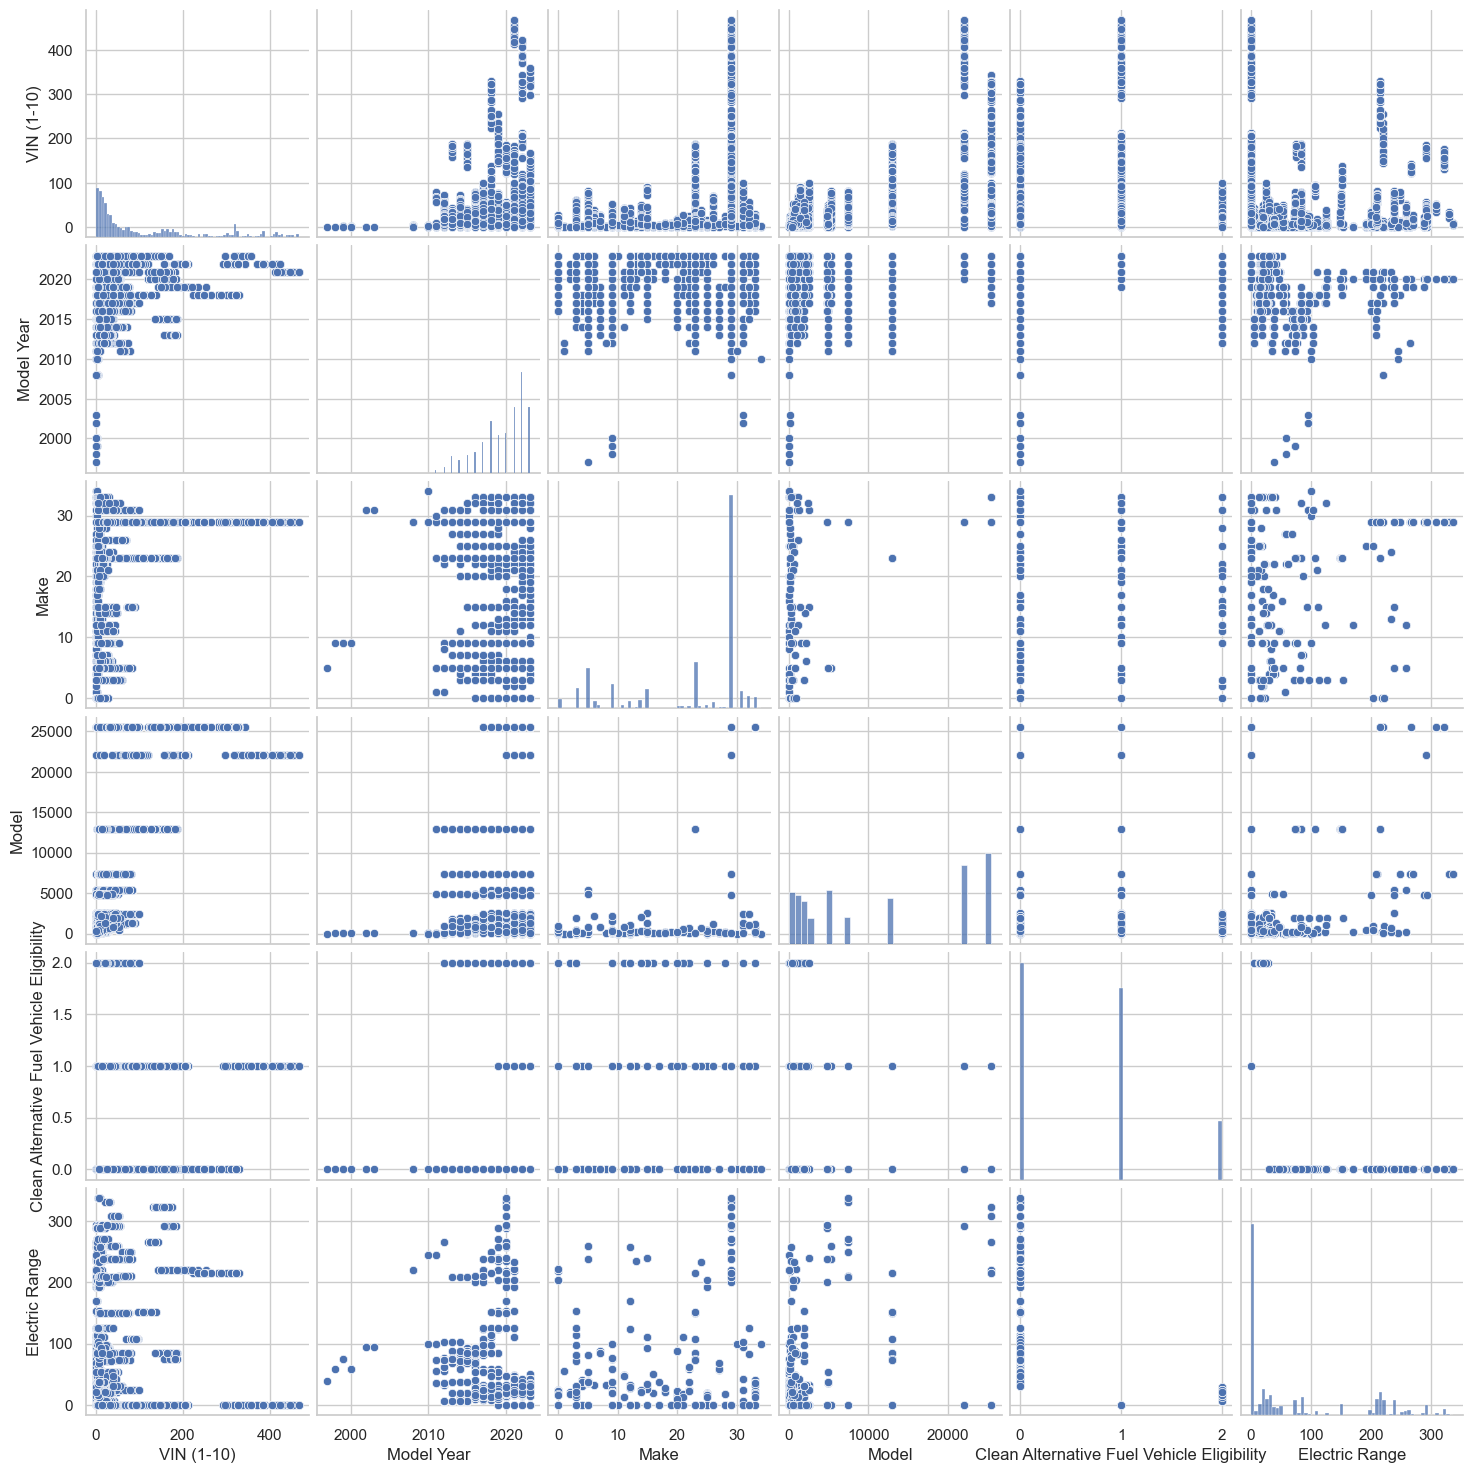

In [39]:
# plot a pairplot of selected feature
sns.pairplot(train, vars=['VIN (1-10)', 'Model Year', 'Make', 'Model', 
                          'Clean Alternative Fuel Vehicle Eligibility', 'Electric Range'])
plt.show()

The graph above justifies that there are not many features that have a strong linear correlation between features.

# Modeling

In [40]:
def plot_cm(cm, chart):

    # set figure size and title
    plt.figure(figsize=(6, 5))
    plt.suptitle(f'Confusion Matrix of {chart}', y=1)

    # initialize TP, TN, FN, and FP counts
    group_names = ['True Negative', 'False Negative', 'False Positive', 'True Positive']
    group_initial = ['(TN)','(FN)','(FP)','(TP)']
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

    # create label strings with counts and percentages
    labels = [f"{v1}\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_names, group_initial, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # plot heatmap of the confusion matrix
    g = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    g.set_xlabel('Actual')
    g.set_ylabel('Predicted')
    
    plt.show()

In [41]:
# show shape of train
train.shape

(130440, 18)

In [42]:
train.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude
0,25,709,471,41,98908.0,2018,29,4792,0,0,238,0,14.0,141151601,968,5.307700e+10,-120.56916,46.58514
1,1,4344,521,41,98370.0,2021,11,782,1,0,47,0,23.0,171566447,76184,5.303509e+10,-122.64681,47.73689
2,221,68477,22894,41,98199.0,2019,29,25532,0,0,220,0,36.0,9426525,24236,5.303301e+10,-122.40092,47.65908
3,172,68477,22894,41,98119.0,2013,23,12960,0,0,75,0,36.0,211807760,24236,5.303301e+10,-122.36840,47.64586
4,62,4694,656,41,98516.0,2017,29,7399,0,0,210,0,22.0,185810306,76184,5.306701e+10,-122.75379,47.06316


## Train Test Splitting

In [43]:
sns.set_theme(style="white")

# initialize X as features and y as target
X = train.drop('Electric Vehicle Type', axis=1).values
y = train['Electric Vehicle Type'].values

# split the data into train and test sets with a test size of 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=21)

## Sampling

In [44]:
# count the occurrences of target value in the 'Electric Vehicle Type' column
train['Electric Vehicle Type'].value_counts()

0    100153
1     30287
Name: Electric Vehicle Type, dtype: int64

The number of target classes indicates an imbalanced condition. This needs to be avoided so that the model does not cause bias. To overcome this, it is necessary to do sampling so that the number of target classes approaches a balanced condition.

In [45]:
# initialize a NearMiss for undersampling
ns = NearMiss()

# perform undersampling using NearMiss and obtain the resampled dataset
print("Original dataset shape:", Counter(y_train))
X_train_resampled, y_train_resampled = ns.fit_resample(X_train, y_train)
print("Resample dataset shape:", Counter(y_train_resampled))

Original dataset shape: Counter({0: 70107, 1: 21201})
Resample dataset shape: Counter({0: 21201, 1: 21201})


## Naive Bayes

In [46]:
# initialize the Naive Bayes classifier and fit it to the resampled training data
NB_classifier = GaussianNB()
NB_classifier.fit(X_train_resampled, y_train_resampled)

# make predictions on the test data
y_pred = NB_classifier.predict(X_test)

# calculate metric evaluation and confusion matrix
accurary = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Accuracy     :", accurary)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Accuracy     : 0.7134825718082388
ROC AUC Score: 0.5246606315250214
Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.88      0.82     30046
           1       0.30      0.17      0.22      9086

    accuracy                           0.71     39132
   macro avg       0.54      0.52      0.52     39132
weighted avg       0.67      0.71      0.68     39132

Confusion Matrix:

 [[26356  3690]
 [ 7522  1564]]


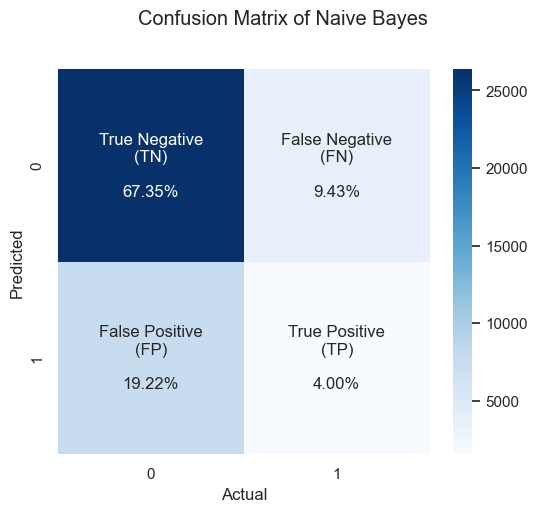

In [47]:
chart = 'Naive Bayes'

# plot the confusion matrix
plot_cm(cm, chart)

**Class 0**: BEV (Battery Electric Vehicle)<br>
**Class 1**: PHEV (Plug-in Hybrid Electric Vehicle)

### Cross Validation

In [48]:
# initialize a K-Fold cross-validation object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# compute the cross-validation accuracy scores and ROC AUC scores for the untuned NB classifier
nb_before_tuned_cv_acc_scores = cross_val_score(NB_classifier, X_train_resampled, y_train_resampled, 
                                            cv=kf, n_jobs=-1, scoring='accuracy').mean()
nb_before_tuned_cv_rocauc_scores = cross_val_score(NB_classifier, X_train_resampled, y_train_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation accuracy and ROC AUC score for untuned {chart} after a 10 fold cross validation:")
print("Accuracy :", nb_before_tuned_cv_acc_scores)
print("ROC AUC  :", nb_before_tuned_cv_rocauc_scores)

The cross-validation accuracy and ROC AUC score for untuned Naive Bayes after a 10 fold cross validation:
Accuracy : 0.5797365564369386
ROC AUC  : 0.8035406249932546


In [49]:
print(NB_classifier.get_params())

{'priors': None, 'var_smoothing': 1e-09}


### Hyperparameter Tuning

In [50]:
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

# initialize GridSearchCV objects for accuracy and ROC AUC score
grid_nb_acc = GridSearchCV(NB_classifier, param_grid, cv=kf, n_jobs=-1, scoring='accuracy')
grid_nb_rocauc = GridSearchCV(NB_classifier, param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform grid search for accuracy and ROC AUC score
grid_nb_acc.fit(X_train_resampled, y_train_resampled)
grid_nb_rocauc.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             scoring='roc_auc')

In [51]:
best_hyperparams_acc = grid_nb_acc.best_params_
best_hyperparams_rocauc = grid_nb_rocauc.best_params_

print("Best hyperparameters for accuracy and ROC AUC:")
print("Accuracy :\n", best_hyperparams_acc)
print("ROC AUC  :\n", best_hyperparams_rocauc)

nb_after_tuned_cv_acc_scores = grid_nb_acc.best_score_
nb_after_tuned_cv_rocauc_scores = grid_nb_rocauc.best_score_

print(f"\nThe cross-validation accuracy and ROC AUC score for tuned {chart} after a 10 fold cross validation:")
print("Accuracy :", nb_after_tuned_cv_acc_scores)
print("ROC AUC  :", nb_after_tuned_cv_rocauc_scores)

best_nb_model = grid_nb_acc.best_estimator_

Best hyperparameters for accuracy and ROC AUC:
Accuracy :
 {'var_smoothing': 1e-09}
ROC AUC  :
 {'var_smoothing': 1e-09}

The cross-validation accuracy and ROC AUC score for tuned Naive Bayes after a 10 fold cross validation:
Accuracy : 0.5797365564369386
ROC AUC  : 0.8035406249932546


In [52]:
best_nb_fit_for_train_data_acc = cross_val_score(best_nb_model, X_train_resampled, y_train_resampled,
                                             cv=kf, n_jobs=-1).mean()

best_nb_fit_for_train_data_rocauc = cross_val_score(best_nb_model, X_train_resampled, y_train_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("="*55)
print("Train Data")
print("Accuracy :", best_nb_fit_for_train_data_acc)
print("ROC AUC  :", best_nb_fit_for_train_data_rocauc)

best_nb_fit_for_test_data_acc = cross_val_score(best_nb_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_nb_fit_for_test_data_rocauc = cross_val_score(best_nb_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("="*55)
print("Test Data")
print("Accuracy :", best_nb_fit_for_test_data_acc)
print("ROC AUC  :", best_nb_fit_for_test_data_rocauc)

Train Data
Accuracy : 0.5797365564369386
ROC AUC  : 0.8035406249932546
Test Data
Accuracy : 0.7671466755012999
ROC AUC  : 0.7087701073628724


## Logistic Regression

In [53]:
# initialize the Logistic Regression classifier and fit it to the resampled training data
LR_classifier = LogisticRegression()
LR_classifier.fit(X_train_resampled, y_train_resampled)

# make predictions on the test data
y_pred = LR_classifier.predict(X_test)

# calculate metric evaluation and confusion matrix
accurary = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Accuracy     :", accurary)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Accuracy     : 0.4863538791781662
ROC AUC Score: 0.5100391887183213
Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.47      0.58     30046
           1       0.24      0.55      0.33      9086

    accuracy                           0.49     39132
   macro avg       0.51      0.51      0.46     39132
weighted avg       0.65      0.49      0.52     39132

Confusion Matrix:

 [[13996 16050]
 [ 4050  5036]]


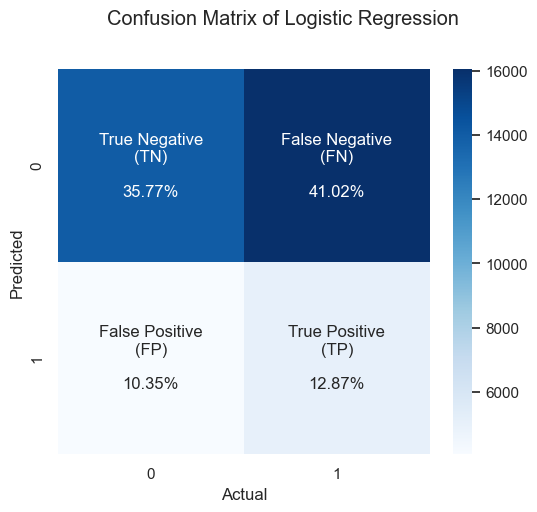

In [54]:
chart = 'Logistic Regression'

# plot the confusion matrix
plot_cm(cm, chart)

**Class 0**: BEV (Battery Electric Vehicle)<br>
**Class 1**: PHEV (Plug-in Hybrid Electric Vehicle)

### Cross Validation

In [55]:
# compute the cross-validation accuracy scores and ROC AUC scores for the untuned LR classifier
lr_before_tuned_cv_acc_scores = cross_val_score(LR_classifier, X_train_resampled, y_train_resampled, 
                                            cv=kf, n_jobs=-1, scoring='accuracy').mean()
lr_before_tuned_cv_rocauc_scores = cross_val_score(LR_classifier, X_train_resampled, y_train_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation accuracy and ROC AUC score for untuned {chart} after a 10 fold cross validation:")
print("Accuracy :", lr_before_tuned_cv_acc_scores)
print("ROC AUC  :", lr_before_tuned_cv_rocauc_scores)

The cross-validation accuracy and ROC AUC score for untuned Logistic Regression after a 10 fold cross validation:
Accuracy : 0.5607754267638907
ROC AUC  : 0.5499202442449941


In [56]:
print(LR_classifier.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Hyperparameter Tuning

In [57]:
param_grid = {
    'penalty': ['l1', 'l2', '13', '14'],
    'C': [0.1, 1, 10, 20],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 200, 300],
    'random_state': [None, 42, 21],
    'warm_start': [True, False]
}

# initialize GridSearchCV objects for accuracy and ROC AUC score
grid_lr_acc = GridSearchCV(LR_classifier, param_grid, cv=kf, n_jobs=-1, scoring='accuracy')
grid_lr_rocauc = GridSearchCV(LR_classifier, param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform grid search for accuracy and ROC AUC score
grid_lr_acc.fit(X_train_resampled, y_train_resampled)
grid_lr_rocauc.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 20],
                         'class_weight': [None, 'balanced'],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', '13', '14'],
                         'random_state': [None, 42, 21],
                         'warm_start': [True, False]},
             scoring='roc_auc')

In [58]:
best_hyperparams_acc = grid_lr_acc.best_params_
best_hyperparams_rocauc = grid_lr_rocauc.best_params_

print("Best hyperparameters for accuracy and ROC AUC:")
print("Accuracy :\n", best_hyperparams_acc)
print("ROC AUC  :\n", best_hyperparams_rocauc)

lr_after_tuned_cv_acc_scores = grid_lr_acc.best_score_
lr_after_tuned_cv_rocauc_scores = grid_lr_rocauc.best_score_

print(f"\nThe cross-validation accuracy and ROC AUC score for tuned {chart} after a 10 fold cross validation:")
print("Accuracy :", lr_after_tuned_cv_acc_scores)
print("ROC AUC  :", lr_after_tuned_cv_rocauc_scores)

best_lr_model = grid_lr_acc.best_estimator_

Best hyperparameters for accuracy and ROC AUC:
Accuracy :
 {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'random_state': None, 'warm_start': True}
ROC AUC  :
 {'C': 0.1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'random_state': None, 'warm_start': True}

The cross-validation accuracy and ROC AUC score for tuned Logistic Regression after a 10 fold cross validation:
Accuracy : 0.561317868471747
ROC AUC  : 0.5499202442449941


In [59]:
best_lr_fit_for_train_data_acc = cross_val_score(best_lr_model, X_train_resampled, y_train_resampled,
                                             cv=kf, n_jobs=-1).mean()

best_lr_fit_for_train_data_rocauc = cross_val_score(best_lr_model, X_train_resampled, y_train_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("="*55)
print("Train Data")
print("Accuracy :", best_lr_fit_for_train_data_acc)
print("ROC AUC  :", best_lr_fit_for_train_data_rocauc)

best_lr_fit_for_test_data_acc = cross_val_score(best_lr_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_lr_fit_for_test_data_rocauc = cross_val_score(best_lr_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("="*55)
print("Test Data")
print("Accuracy :", best_lr_fit_for_test_data_acc)
print("ROC AUC  :", best_lr_fit_for_test_data_rocauc)

Train Data
Accuracy : 0.561317868471747
ROC AUC  : 0.5499199547158597
Test Data
Accuracy : 0.5190637421662603
ROC AUC  : 0.5000523350108292


## Random Forest

In [60]:
# initialize the Random Forest classifier and fit it to the resampled training data
RF_classifier = RandomForestClassifier(n_estimators=100)
RF_classifier.fit(X_train_resampled, y_train_resampled)

# make predictions on the test data
y_pred = RF_classifier.predict(X_test)

# calculate metric evaluation and confusion matrix
accurary = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Accuracy     :", accurary)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Accuracy     : 0.9987989369314116
ROC AUC Score: 0.9991794773730833
Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     30046
           1       0.99      1.00      1.00      9086

    accuracy                           1.00     39132
   macro avg       1.00      1.00      1.00     39132
weighted avg       1.00      1.00      1.00     39132

Confusion Matrix:

 [[30000    46]
 [    1  9085]]


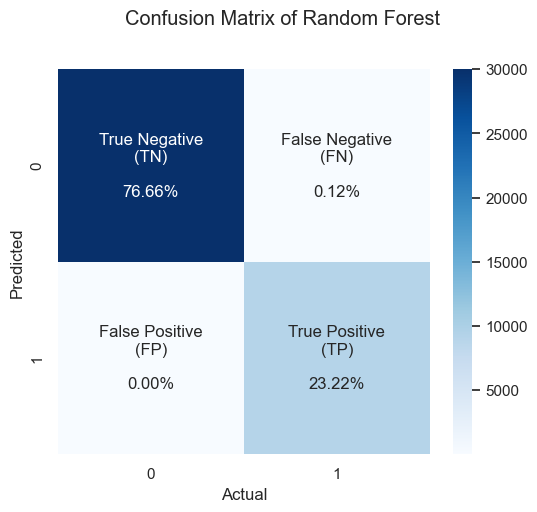

In [61]:
chart = 'Random Forest'

# plot the confusion matrix
plot_cm(cm, chart)

**Class 0**: BEV (Battery Electric Vehicle)<br>
**Class 1**: PHEV (Plug-in Hybrid Electric Vehicle)

### Cross Validation

In [62]:
# compute the cross-validation accuracy scores and ROC AUC scores for the untuned RF classifier
rf_before_tuned_cv_acc_scores = cross_val_score(RF_classifier, X_train_resampled, y_train_resampled, 
                                            cv=kf, n_jobs=-1, scoring='accuracy').mean()
rf_before_tuned_cv_rocauc_scores = cross_val_score(RF_classifier, X_train_resampled, y_train_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation accuracy and ROC AUC score for untuned {chart} after a 10 fold cross validation:")
print("Accuracy :", rf_before_tuned_cv_acc_scores)
print("ROC AUC  :", rf_before_tuned_cv_rocauc_scores)

The cross-validation accuracy and ROC AUC score for untuned Random Forest after a 10 fold cross validation:
Accuracy : 0.9995990788484381
ROC AUC  : 0.9999728889286745


In [63]:
print(RF_classifier.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Hyperparameter Tuning

In [64]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'bootstrap': [True, False],
}

# initialize GridSearchCV objects for accuracy and ROC AUC score
grid_rf_acc = GridSearchCV(RF_classifier, param_grid, cv=kf, n_jobs=-1, scoring='accuracy')
grid_rf_rocauc = GridSearchCV(RF_classifier, param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform grid search for accuracy and ROC AUC score
grid_rf_acc.fit(X_train_resampled, y_train_resampled)
grid_rf_rocauc.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 5, 10],
                         'n_estimators': [100, 150]},
             scoring='roc_auc')

In [65]:
best_hyperparams_acc = grid_rf_acc.best_params_
best_hyperparams_rocauc = grid_rf_rocauc.best_params_

print("Best hyperparameters for accuracy and ROC AUC:")
print("Accuracy :\n", best_hyperparams_acc)
print("ROC AUC  :\n", best_hyperparams_rocauc)

rf_after_tuned_cv_acc_scores = grid_rf_acc.best_score_
rf_after_tuned_cv_rocauc_scores = grid_rf_rocauc.best_score_

print(f"\nThe cross-validation accuracy and ROC AUC score for tuned {chart} after a 10 fold cross validation:")
print("Accuracy :", rf_after_tuned_cv_acc_scores)
print("ROC AUC  :", rf_after_tuned_cv_rocauc_scores)

best_rf_model = grid_rf_acc.best_estimator_

Best hyperparameters for accuracy and ROC AUC:
Accuracy :
 {'bootstrap': False, 'max_depth': None, 'n_estimators': 100}
ROC AUC  :
 {'bootstrap': False, 'max_depth': 10, 'n_estimators': 150}

The cross-validation accuracy and ROC AUC score for tuned Random Forest after a 10 fold cross validation:
Accuracy : 0.9997169922544076
ROC AUC  : 0.9999873801962311


In [66]:
best_rf_fit_for_train_data_acc = cross_val_score(best_rf_model, X_train_resampled, y_train_resampled,
                                             cv=kf, n_jobs=-1).mean()

best_rf_fit_for_train_data_rocauc = cross_val_score(best_rf_model, X_train_resampled, y_train_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("="*55)
print("Train Data")
print("Accuracy :", best_rf_fit_for_train_data_acc)
print("ROC AUC  :", best_rf_fit_for_train_data_rocauc)

best_rf_fit_for_test_data_acc = cross_val_score(best_rf_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_rf_fit_for_test_data_rocauc = cross_val_score(best_rf_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("="*55)
print("Test Data")
print("Accuracy :", best_rf_fit_for_test_data_acc)
print("ROC AUC  :", best_rf_fit_for_test_data_rocauc)

Train Data
Accuracy : 0.9996934129099134
ROC AUC  : 0.9999964612899683
Test Data
Accuracy : 0.9997188988240788
ROC AUC  : 0.9999989938625115


## XGBoost

In [67]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# initialize the XGBoost classifier and fit it to the resampled training data
XGB_classifier = xgb.XGBClassifier(**params)
XGB_classifier.fit(X_train_resampled, y_train_resampled)

# make predictions on the test data
y_pred = XGB_classifier.predict(X_test)

# calculate metric evaluation and confusion matrix
accurary = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Accuracy     :", accurary)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Accuracy     : 0.9981089645303077
ROC AUC Score: 0.9986150006192721
Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     30046
           1       0.99      1.00      1.00      9086

    accuracy                           1.00     39132
   macro avg       1.00      1.00      1.00     39132
weighted avg       1.00      1.00      1.00     39132

Confusion Matrix:

 [[29976    70]
 [    4  9082]]


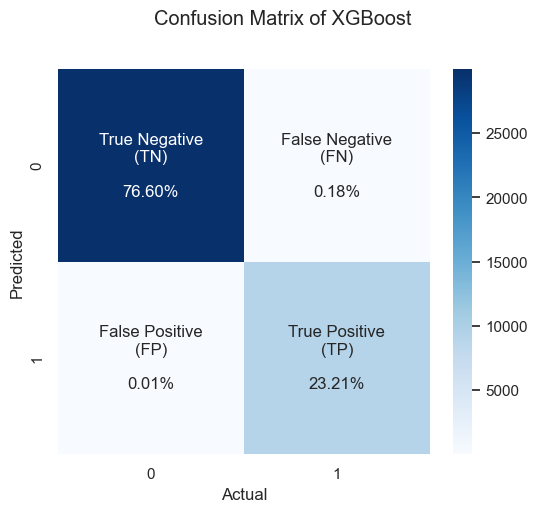

In [68]:
chart = 'XGBoost'

# plot the confusion matrix
plot_cm(cm, chart)

**Class 0**: BEV (Battery Electric Vehicle)<br>
**Class 1**: PHEV (Plug-in Hybrid Electric Vehicle)

### Cross Validation

In [69]:
# compute the cross-validation accuracy scores and ROC AUC scores for the untuned XGB classifier
xg_before_tuned_cv_acc_scores = cross_val_score(XGB_classifier, X_train_resampled, y_train_resampled, 
                                            cv=kf, n_jobs=-1, scoring='accuracy').mean()
xg_before_tuned_cv_rocauc_scores = cross_val_score(XGB_classifier, X_train_resampled, y_train_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation accuracy and ROC AUC score for untuned {chart} after a 10 fold cross validation:")
print("Accuracy :", xg_before_tuned_cv_acc_scores)
print("ROC AUC  :", xg_before_tuned_cv_rocauc_scores)

The cross-validation accuracy and ROC AUC score for untuned XGBoost after a 10 fold cross validation:
Accuracy : 0.9997405771600683
ROC AUC  : 0.9999810731500431


In [70]:
print(XGB_classifier.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': 0, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.1, 'seed': 42}


### Hyperparameter Tuning

In [71]:
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'random_state': [42, 21, 10]
}

# initialize GridSearchCV objects for accuracy and ROC AUC score
grid_xgb_acc = GridSearchCV(XGB_classifier, param_grid, cv=kf, n_jobs=-1, scoring='accuracy')
grid_xgb_rocauc = GridSearchCV(XGB_classifier, param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform grid search for accuracy and ROC AUC score
grid_xgb_acc.fit(X_train_resampled, y_train_resampled)
grid_xgb_rocauc.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.1,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, mi

In [72]:
best_hyperparams_acc = grid_xgb_acc.best_params_
best_hyperparams_rocauc = grid_xgb_rocauc.best_params_

print("Best hyperparameters for accuracy and ROC AUC:")
print("Accuracy :\n", best_hyperparams_acc)
print("ROC AUC  :\n", best_hyperparams_rocauc)

xgb_after_tuned_cv_acc_scores = grid_xgb_acc.best_score_
xgb_after_tuned_cv_rocauc_scores = grid_xgb_rocauc.best_score_

print(f"\nThe cross-validation accuracy and ROC AUC score for tuned {chart} after a 10 fold cross validation:")
print("Accuracy :", xgb_after_tuned_cv_acc_scores)
print("ROC AUC  :", xgb_after_tuned_cv_rocauc_scores)

best_xgb_model = grid_xgb_acc.best_estimator_

Best hyperparameters for accuracy and ROC AUC:
Accuracy :
 {'learning_rate': 0.1, 'max_depth': 5, 'random_state': 42}
ROC AUC  :
 {'learning_rate': 0.1, 'max_depth': 5, 'random_state': 42}

The cross-validation accuracy and ROC AUC score for tuned XGBoost after a 10 fold cross validation:
Accuracy : 0.9997877469713888
ROC AUC  : 0.9999996662334258


In [73]:
best_xgb_fit_for_train_data_acc = cross_val_score(best_xgb_model, X_train_resampled, y_train_resampled,
                                             cv=kf, n_jobs=-1).mean()

best_xgb_fit_for_train_data_rocauc = cross_val_score(best_xgb_model, X_train_resampled, y_train_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("="*55)
print("Train Data")
print("Accuracy :", best_xgb_fit_for_train_data_acc)
print("ROC AUC  :", best_xgb_fit_for_train_data_rocauc)

best_xgb_fit_for_test_data_acc = cross_val_score(best_xgb_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_xgb_fit_for_test_data_rocauc = cross_val_score(best_xgb_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("="*55)
print("Test Data")
print("Accuracy :", best_xgb_fit_for_test_data_acc)
print("ROC AUC  :", best_xgb_fit_for_test_data_rocauc)

Train Data
Accuracy : 0.9997877469713888
ROC AUC  : 0.9999996662334258
Test Data
Accuracy : 0.9998722338611348
ROC AUC  : 0.9999956267031667


## Model Evaluation

### Model Selection

In [74]:
dict_result = {'Model' :['Naive Bayes', 'Logistic Regression', 'Random Forest', 'XGBoost'],
                "Accuracy (train)": [best_nb_fit_for_train_data_acc, best_lr_fit_for_train_data_acc, 
                                             best_rf_fit_for_train_data_acc, best_xgb_fit_for_train_data_acc],
                "Accuracy (test)": [best_nb_fit_for_test_data_acc, best_lr_fit_for_test_data_acc, 
                                            best_rf_fit_for_test_data_acc, best_xgb_fit_for_test_data_acc],
                "ROC-AUC (train)": [best_nb_fit_for_train_data_rocauc, best_lr_fit_for_train_data_rocauc, 
                                             best_rf_fit_for_train_data_rocauc, best_xgb_fit_for_train_data_rocauc],
                "ROC-AUC (test)": [best_nb_fit_for_test_data_rocauc, best_lr_fit_for_test_data_rocauc, 
                                            best_rf_fit_for_test_data_rocauc, best_xgb_fit_for_test_data_rocauc]}

model_result = pd.DataFrame(dict_result).sort_values(by=['ROC-AUC (test)', 'Accuracy (test)'], ascending= False).reset_index(drop=True)
model_result

,Model,Accuracy (train),Accuracy (test),ROC-AUC (train),ROC-AUC (test)
0,Random Forest,0.999693,0.999719,0.999996,0.999999
1,XGBoost,0.999788,0.999872,1.000000,0.999996
2,Naive Bayes,0.579737,0.767147,0.803541,0.708770
3,Logistic Regression,0.561318,0.519064,0.549920,0.500052


In this particular case, the relative proportions of False Positives (FP) and False Negatives (FN) do not have significant implications for the business. Consequently, the primary focus is to develop a model that can accurately predict the target variable. Therefore, the evaluation metrics employed are accuracy, which measures the proportion of correct predictions out of the total samples, and the ROC-AUC score, which assesses the model's ability to discriminate between the two classes. 

By prioritizing accuracy, the goal is to maximize the overall correctness of predictions without specifically emphasizing the trade-off between FP and FN. The ROC-AUC score provides a comprehensive measure of the model's performance across various classification thresholds and indicates the capability of the model to correctly rank the classes. This approach allows for a more balanced evaluation and selection of the model based on its ability to predict the target variable accurately.

The best model was chosen from the model that produced the highest average ROC-AUC score for the test data and does not indicate overfitting and underfitting. Based on the table above, the model chosen is **Random Forest** with an average **ROC-AUC score for test data of 0.999999**.

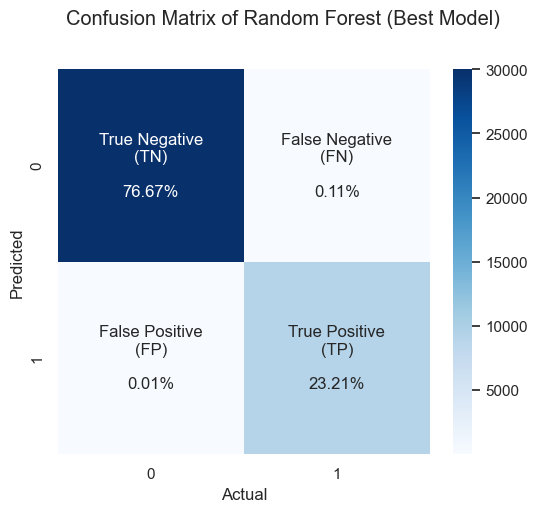

In [75]:
chart = 'Random Forest (Best Model)'

cm = confusion_matrix(y_test, best_rf_model.predict(X_test))

plot_cm(cm, chart)

**Class 0**: BEV (Battery Electric Vehicle)<br>
**Class 1**: PHEV (Plug-in Hybrid Electric Vehicle)

The heatmap above shows the confusion matrix of the best model after the tuning process. Produces True Negative (TN) 76.68%, True Positive (TP) 23.22%, False Negative (FN) 0.00%, False Positive (FP) 0.10% which means the model has high accuracy in predicting class.

### ROC AUC Curve

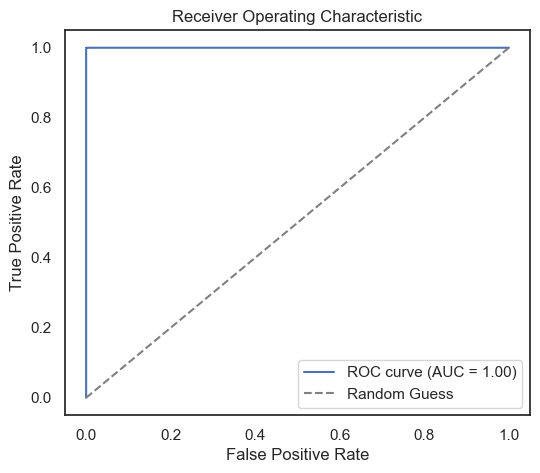

In [76]:
from sklearn.metrics import roc_curve, auc

y_prob = best_rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

The graph above shows the ROC AUC curve with an almost perfect score of 0.999999. This means that the model works well in predicting each class.

### Feature Importance

In [77]:
train.shape

(130440, 18)

In [78]:
X = train.drop('Electric Vehicle Type', axis=1)
y = train['Electric Vehicle Type']

In [79]:
X.columns

Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Clean Alternative Fuel Vehicle Eligibility',
       'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Electric Utility', '2020 Census Tract', 'Longitude', 'Latitude'],
      dtype='object')

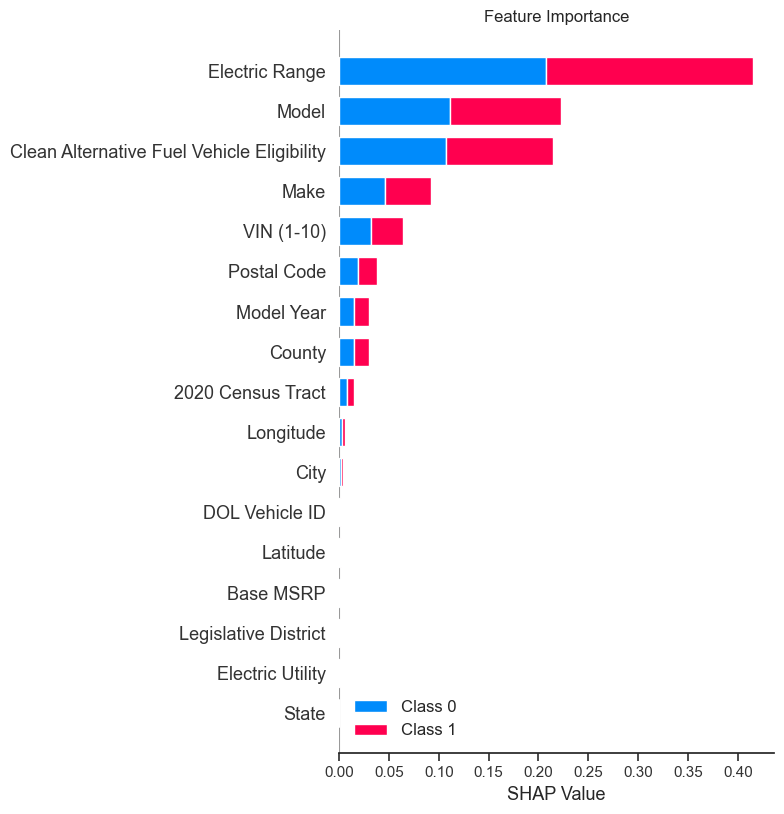

In [80]:
# define an explainer object using the best model, get the importance values, and plot into a bar plot
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type='bar', show=False)

plt.xlabel('SHAP Value')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

**Class 0**: BEV (Battery Electric Vehicle)<br>
**Class 1**: PHEV (Plug-in Hybrid Electric Vehicle)

The plot of feature importance represents the relative importance of each feature in a machine learning model. It provides insights into which features have the most significant impact on the model's predictive performance. A higher importance score indicates a stronger influence on the model's predictions. These features can provide valuable insights into the underlying patterns or relationships in the data.

Based on the graph above, important features are known, such as 'Electric Range', 'Model', 'Clean Alternative Fuel Vehicle Eligibility', 'Make', and others.

In [81]:
# get the importance values and convert to dataframe
importance = best_rf_model.feature_importances_

feature_importance = pd.DataFrame({'Feature': X.columns, 
                                   'Importance': importance})\
                                    .sort_values(by='Importance', ascending=False)\
                                    .reset_index(drop=True)
feature_importance.head()

,Feature,Importance
0,Electric Range,0.409250
1,Model,0.182939
2,Clean Alternative Fuel Vehicle Eligibility,0.166775
3,Make,0.085471
4,VIN (1-10),0.050697


# Prediction

In [82]:
# create a dataframe to store the predictions and concatenate the predictions with the original train dataframe
predictions = pd.DataFrame({'Prediction': best_rf_model.predict(train.drop('Electric Vehicle Type', axis=1))})
result = pd.concat([predictions, train], axis=1).rename(columns={'Electric Vehicle Type': 'Actual', 'Prediction': 'Predicted'})

# select the desired columns for the result DataFrame
columns = ['Predicted', 'Actual', 'VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make',
           'Model', 'Clean Alternative Fuel Vehicle Eligibility', 'Electric Range', 'Base MSRP',
           'Legislative District', 'DOL Vehicle ID', 'Electric Utility', '2020 Census Tract', 'Longitude', 'Latitude']
result = result[columns]

# map the numerical labels to their corresponding vehicle types
result['Electric Vehicle Type (Actual)'] = result['Actual'].map({1: 'PHEV', 0: 'BEV'})
result['Electric Vehicle Type (Predicted)'] = result['Predicted'].map({1: 'PHEV', 0: 'BEV'})

# convert specific columns to integer type
integer_columns = ['Predicted', 'Actual', 'Postal Code', 'Model Year', 'Electric Range', 'Base MSRP',
                   'Legislative District', '2020 Census Tract']
result[integer_columns] = result[integer_columns].astype('Int64')

result.head()

,Predicted,Actual,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,...,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude,Electric Vehicle Type (Actual),Electric Vehicle Type (Predicted)
0,0,0,25,709,471,41,98908,2018,29,4792,...,238,0,14,141151601,968,53077001100,-120.56916,46.58514,BEV,BEV
1,1,1,1,4344,521,41,98370,2021,11,782,...,47,0,23,171566447,76184,53035090400,-122.64681,47.73689,PHEV,PHEV
2,0,0,221,68477,22894,41,98199,2019,29,25532,...,220,0,36,9426525,24236,53033005803,-122.40092,47.65908,BEV,BEV
3,0,0,172,68477,22894,41,98119,2013,23,12960,...,75,0,36,211807760,24236,53033005804,-122.36840,47.64586,BEV,BEV
4,0,0,62,4694,656,41,98516,2017,29,7399,...,210,0,22,185810306,76184,53067012226,-122.75379,47.06316,BEV,BEV


In [83]:
# initialize the list of columns to copy
columns_to_copy = ['VIN (1-10)', 'County', 'City', 'State', 'Make', 'Model', 'Clean Alternative Fuel Vehicle Eligibility', 
                   'DOL Vehicle ID', 'Electric Utility']

# iterate over list to copy values
for column in columns_to_copy:
    result[column] = df[column]
result.head()

,Predicted,Actual,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,...,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude,Electric Vehicle Type (Actual),Electric Vehicle Type (Predicted)
0,0,0,5YJXCAE26J,Yakima,Yakima,Washington,98908,2018,TESLA,MODEL X,...,238,0,14,141151601,PACIFICORP,53077001100,-120.56916,46.58514,BEV,BEV
1,1,1,JHMZC5F37M,Kitsap,Poulsbo,Washington,98370,2021,HONDA,CLARITY,...,47,0,23,171566447,PUGET SOUND ENERGY INC,53035090400,-122.64681,47.73689,PHEV,PHEV
2,0,0,5YJ3E1EB0K,King,Seattle,Washington,98199,2019,TESLA,MODEL 3,...,220,0,36,9426525,CITY OF SEATTLE,53033005803,-122.40092,47.65908,BEV,BEV
3,0,0,1N4AZ0CP5D,King,Seattle,Washington,98119,2013,NISSAN,LEAF,...,75,0,36,211807760,CITY OF SEATTLE,53033005804,-122.36840,47.64586,BEV,BEV
4,0,0,5YJSA1E21H,Thurston,Lacey,Washington,98516,2017,TESLA,MODEL S,...,210,0,22,185810306,PUGET SOUND ENERGY INC,53067012226,-122.75379,47.06316,BEV,BEV


In [84]:
# export data to csv file
result.to_csv('result.csv', index=False)
feature_importance.to_csv('feature_importance.csv', index=False)

Based on the entire process, the following are the results:

- The best model obtained is Random Forest which produces accuracy and ROC-AUC scores of 0.999617 and 0.999998, respectively.
- Electric vehicles of the BEV (Battery Electric Vehicle) type have the largest percentage of 76.8%.
- King County has the highest number of electric vehicles with 41.9% for BEV and 10.6% for PHEV.
- The city of Seattle has the second highest number of electric vehicles at 13.7% for BEV and 3.9% for PHEV.
- Washington state is the state with the most electric vehicles with a total percentage of 99.7% (BEV and PHEV).
- Electric vehicles with a model year of 2022 account for the largest share with 18.3% for BEV and 3.2% for PHEV.
- Electric vehicles made by Tesla were the most numerous with 45.7% (BEV and PHEV).
- Electric vehicles are most likely to meet the clean fuel (low emission) vehicle eligibility requirements at 46.4% (BEV and PHEV), followed by electric vehicles with unknown eligibility status at 41% (BEV and PHEV), and electric vehicles with ineligible status at 12.6% (BEV and PHEV).
- Electric vehicles with Puget Sound Energy electric utilities were the most common at 58.4% (BEV and PHEV).